# Python機械学習 勉強会 第十回「データの表現と特徴量エンジニアリング1」

参考文献：  
Pythonではじめる機械学習　4章  
https://github.com/amueller/introduction_to_ml_with_python/blob/master/04-representing-data-feature-engineering.ipynb

scikit-learnドキュメント：  
https://scikit-learn.org/stable/documentation.html

In [1]:
%matplotlib inline
from preamble import *
from sklearn.model_selection import train_test_split

<br>

---

## はじめに

今回は以下の内容を取り組む

* カテゴリ変数
* ビニング、離散化、線形モデル、決定木
* 交互作用と多項式

<br>

---

## 4 データの表現と特徴量エンジニアリング

これまでは、浮動小数点数配列として得られるデータを主に扱ってきた。  
それぞれの列はデータポイントを表す**連続値特徴量**である。

それ以外にも**カテゴリ特徴量(離散値特徴量)**が存在し、一般的によく使われている。

* 連続値特徴量の例　：ピクセルの明るさ、花の大きさ
* カテゴリ特徴量の例：製品のブランド名や色など

<br>

ここではこれらの特徴量についてデータを(モデルにとって)正しく表現する手段である、  
**特徴量エンジニアリング(feature engineering)**について学んでいく。

<br>

---

### 4.1 カテゴリ変数

ここではカテゴリ変数(カテゴリ特徴量)を扱う方法を説明する。  
具体的に、1994年の一斉調査で得られたアメリカ合衆国成人の収入データセットを例に説明する。

In [2]:
import os
# このファイルにはコラム名を含んだヘッダがないので、header=Noneを指定し、
# コラム名を"names"で明示的に指定
adult_path = os.path.join(mglearn.datasets.DATA_PATH, "adult.data")
data = pd.read_csv(
    adult_path, header=None, index_col=False,
    names=['age', 'workclass', 'fnlwgt', 'education',  'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'gender',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
           'income'])

# 開設のために、いくるかのカラムだけを選択
# age:年齢、workclass:雇用形態、education:教育、gender:性別、hours-per-week:週あたりの労働時間、
# occupation:職業、income:収入
data = data[['age', 'workclass', 'education', 'gender', 'hours-per-week',
             'occupation', 'income']]

display(data.head(11))

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K
5,37,Private,Masters,Female,40,Exec-managerial,<=50K
6,49,Private,9th,Female,16,Other-service,<=50K
7,52,Self-emp-not-inc,HS-grad,Male,45,Exec-managerial,>50K
8,31,Private,Masters,Female,50,Prof-specialty,>50K
9,42,Private,Bachelors,Male,40,Exec-managerial,>50K


このタスクは収入が5万どるを超えるかどうかを判定する、2クラス分類である。  
このデータセットでは、ageとhours-per-weekが連続値特徴量、その他はカテゴリ特徴量。

ここでは、このデータでロジスティック回帰クラス分類器を学習させてみる。

$$
\hat{y} = w[0] * x[0] + w[1] * x[1] + \dots + w[p] * x[p] + b > 0
$$

w[i]とbは訓練セットから学習した係数で、x[i]は入力特徴量を意味する。

この式ではx[i]が数値である場合は意味を持つが、x[2]のように"Masters"や"Bachelors"のような文字列の場合は意味をなさない。  
そこで、これらのカテゴリ変数をモデルに適した表現に変更する必要がある。

<br>

### 4.1.1 ワンホットエンコーディング(ダミー変数)

カテゴリ変数を表現する方法として一般的に用いられている手法に、**ワンホットエンコーディング**がある。  
この手法を用いて作成される特徴量をダミー変数とも呼ぶ。

具体的には、カテゴリ変数を0と1の値を持つ、新しい特徴量に置き換える手法である。

<br>

例えば、workclass特徴量に対してワンホットエンコーディングを適用してみる。  
これらは、"Goverment Employee"、"Private Employee"、"Self Employed"、"Self Employed Incorporated"の4つの値を取るとする。

| workclass                  | State-gov | private Employee | Self Employed | Self Employed Incorporated
|:-:                         |:-:        |:-:               |:-:            |:-:
| State-gov                  | 1         | 0                | 0             | 0
|private Employee            | 0         | 1                | 0             | 0
| Self Employed              | 0         | 0                | 1             | 0
| Self Employed Incorporated | 0         | 0                | 0             | 1

<br>

この表のように、各データポイントに対して、新しい4つの特徴量のうち1つだけが1となり、残りの特徴は0となる。  
このように表現することで、カテゴリ変数をモデルが解釈できるようになる。

ワンホットエンコーディングを実現するには2つの方法がある。  
* Pandasを使う方法
* sckit-learnを使う方法

ここではPandasを使う方法を試してみる。

<br>

データセットを読み込んだら、各列に意味のあるカテゴリデータが含まれているかチェックする。  
例えば、文字の揺れ(maleであったりmanであったり)や、大文字小文字を区別する必要があるか、など。

***value_counts***関数を用いれば、各行に含まれているユニークな値とその数を表示できる

In [3]:
print(data.gender.value_counts())

 Male      21790
 Female    10771
Name: gender, dtype: int64


たとえば、genderにはMaleとFemaleしか存在しないので、既に整理されていることが分かり、  
この特徴量に関してはこのままワンホットエンコーディングして良い事が分かる。  

ここでは省略するが、全てのカテゴリ変数に対してこのチェックは行った方が良い。

<br>

pandasでは、***get_dumies***関数を使って簡単にワンホットエンコーディングできる。

In [4]:
print("Original features:\n", list(data.columns), "\n")

data_dummies = pd.get_dummies(data)

print("Features after get_dummies:\n", list(data_dummies.columns))

Original features:
 ['age', 'workclass', 'education', 'gender', 'hours-per-week', 'occupation', 'income'] 

Features after get_dummies:
 ['age', 'hours-per-week', 'workclass_ ?', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 10th', 'education_ 11th', 'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad', 'education_ Masters', 'education_ Preschool', 'education_ Prof-school', 'education_ Some-college', 'gender_ Female', 'gender_ Male', 'occupation_ ?', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-i

<br>

もともと連続値特徴量であるageとhours-per-weekは変換されていないが、カテゴリ変数は取りうる値ごとに特徴量が拡張されていることが分かる。

In [5]:
display(data_dummies.head())

,age,hours-per-week,workclass_ ?,workclass_ Federal-gov,...,occupation_ Tech-support,occupation_ Transport-moving,income_ <=50K,income_ >50K
0,39,40,0,0,...,0,0,1,0
1,50,13,0,0,...,0,0,1,0
2,38,40,0,0,...,0,0,1,0
3,53,40,0,0,...,0,0,1,0
4,28,40,0,0,...,0,0,1,0


In [6]:
type(data_dummies)

pandas.core.frame.DataFrame

これで、values属性を用いてdata_dumiesをNumpy配列に変換すれば機械学習モデルを学習させることができる。  

* モデルを学習させる前にターゲット変数(income列)を分離する必要あり
* pandasの列インデックスの範囲指定は最後のインデックスを含む仕様となっており、  
    通常のPythonスライスやNumPyのスライスとは異なるので注意

In [7]:
# Pandasのスライスは最後のインデックスを含む
features = data_dummies.loc[:, 'age':'occupation_ Transport-moving']

# NumPy配列に変換
X = features.values

# ターゲット変数を抜き出す
y = data_dummies['income_ >50K'].values

print("X.shape: {}  y.shape: {}".format(X.shape, y.shape))

X.shape: (32561, 44)  y.shape: (32561,)


In [37]:
print(type(features),type(X))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [8]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("Test score: {:.2f}".format(logreg.score(X_test, y_test)))

Test score: 0.81


C:\Users\0060778-z100\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<br>

**注意**  
ワンホットエンコーディングする際は、学習データとテストデータが混じった状態でワンホットエンコーディングすると良い。  
もしくは、それぞれでワンホットエンコーディングした後に、各特徴量が同じであるか確認する必要がある。

もし学習データ、テストデータのどちらかにしか存在しない値があった場合に、それぞれでワンホットエンコーディングすると、  
学習用の特徴量とテスト用の特徴量が異なってしまうからだ。

<br>

### 4.1.2 数値でエンコードされているカテゴリ

前の節で説明したように文字列として表現されているカテゴリ変数ばかりではない。  
数値データであるが実際はカテゴリ変数を意味する特徴量も存在する。

このような場合は、もともと数値データとして保存されているカテゴリ変数の各データを文字列に変換し、  
columnsパラメータで明示的に指定する。

In [9]:
# create a DataFrame with an integer feature and a categorical string feature
demo_df = pd.DataFrame({'Integer Feature': [0, 1, 2, 1],
                        'Categorical Feature': ['socks', 'fox', 'socks', 'box']})
display(demo_df)

demo_df['Integer Feature'] = demo_df['Integer Feature'].astype(str)
pd.get_dummies(demo_df, columns=['Integer Feature', 'Categorical Feature'])

,Integer Feature,Categorical Feature
0,0,socks
1,1,fox
2,2,socks
3,1,box


,Integer Feature_0,Integer Feature_1,Integer Feature_2,Categorical Feature_box,Categorical Feature_fox,Categorical Feature_socks
0,1,0,0,0,0,1
1,0,1,0,0,1,0
2,0,0,1,0,0,1
3,0,1,0,1,0,0


<br>

---

### 4.2 ビニング、離散化、線形モデル、決定木

利用する機械学習のモデルによって、裁量のデータ表現方法が異なってくる。  
例えば、線形モデルと決定木ベースモデルでは、特徴量の表現の相違に関して非常に異なる特性をもつ。

ここで、wave回帰データセットを用いて、線形回帰モデルと決定木回帰モデルを比較してみる。

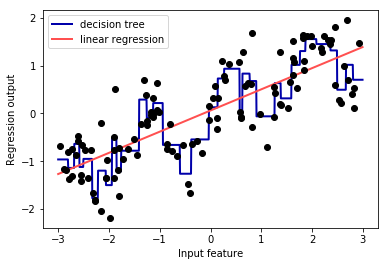

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples=120)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)
plt.plot(line, reg.predict(line), label="decision tree")

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label="linear regression")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

このデータセットは1つの特徴量しかないため、線形モデルでは一本の線となる。  
決定木は複雑なモデルを構築できるが、データの表現に大きく依存する。

線形モデルを連続データに対してより強力にする方法の1つとして、特徴量の**ビニング**、もしくは**離散化**がある。

例えば特徴量の入力レンジ(この例では-3～3)を、10個のビンに分割することを考える。  
ここでは***KBinsDiscretizer***を使って10のビンを作成する。

参考：https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html

In [11]:
from sklearn.preprocessing import KBinsDiscretizer

In [12]:
# strategyに"uniform"を指定することで、全てのビンの横幅を同じにする。
# デフォルトは"quantile"で、全てのビンに入る数が同じになるように分割される
kb = KBinsDiscretizer(n_bins=10, strategy='uniform')
kb.fit(X)

# 各ビンの境界値
print("bin edges: \n", kb.bin_edges_)

bin edges: 
 [array([-2.967, -2.378, -1.789, -1.2  , -0.612, -0.023,  0.566,  1.155,
        1.744,  2.333,  2.921])]


In [13]:
X_binned = kb.transform(X)
X_binned

<120x10 sparse matrix of type '<class 'numpy.float64'>'
	with 120 stored elements in Compressed Sparse Row format>

In [14]:
# もとの特徴量とビン分割後の特徴量の比較
print(X[:10])
X_binned.toarray()[:10]

[[-0.753]
 [ 2.704]
 [ 1.392]
 [ 0.592]
 [-2.064]
 [-2.064]
 [-2.651]
 [ 2.197]
 [ 0.607]
 [ 1.248]]


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

10ビンを指定したので、変換されたデータセットX_binnedには10個の特徴量ができている。

これらの手法を用いて、線形回帰モデルと決定木モデルに適用してみる。

In [15]:
kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense')
kb.fit(X)
X_binned = kb.transform(X)

Text(0.5,0,'Input feature')

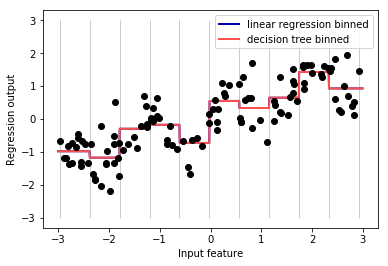

In [16]:
line_binned = kb.transform(line)

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='linear regression binned')

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='decision tree binned')

plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")

分かりにくいが、線形回帰と決定木が完全に同じ予測を行っている。  
ビンごとに特徴量が一定になるので、どのようなモデルであってもビンの中では同じ値を予測することになる。

<br>

ビニングの前後で比較すると、線形モデルに関してはより柔軟になっているが決定木は柔軟性が低下している。  
一般的には決定木にとって特徴量のビニングはメリットがない。  
* もともと決定木はデータを任意の場所で分割して学習できるから

<br>

一方で、線形モデルにおいてはこの変換による表現力増大の効果が期待できる。  
線形モデルを使う場合において、いくつかの特徴量のターゲットが非線形の関係を持つならば、ビニングを使うと表現力を増強できる。

<br>

---

### 4.3 交互作用と多項式

特徴量表現を増加するもう1つの方法として、もとのデータの**交互作用特徴量**と**多項式特徴量**を加える方法がある。  

実例で確認する。  
ビンで分割したwaveデータセットに対して、交互作用を特徴量として加えてみる。

ここでは、それぞれのビンごとに傾きを学習するために、データポイントがどのビンに入っているかを示す特徴量と、  
x軸のどこにあるかを示す特徴量の交互作用を加える。

In [17]:
X_product = np.hstack([X_binned, X * X_binned])
print(X_product.shape)

(120, 20)


In [18]:
print(X.shape, X_binned.shape, X_product.shape)

(120, 1) (120, 10) (120, 20)


In [19]:
X[:3]

array([[-0.753],
       [ 2.704],
       [ 1.392]])

In [20]:
X_binned[:3]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [21]:
X_product[:3]

array([[ 0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   , -0.   , -0.   , -0.   , -0.753, -0.   , -0.   ,
        -0.   , -0.   , -0.   , -0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  2.704],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  1.392,  0.   ,  0.   ]])

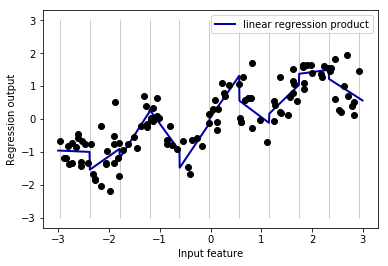

In [22]:
reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, reg.predict(line_product), label='linear regression product')

plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

個々のビンがそれぞれ傾きをもつようになり、より当てはまりが良いモデルになったことがわかる。

ビニング以外に、特徴量の**多項式**を使う方法もある。  
これは、ある特徴量xに対して、$x^2$、$x^3$、$x^4$といった特徴量を作る。

この機能は***PolynomialFeatures***に実装されている。

In [23]:
from sklearn.preprocessing import PolynomialFeatures

# x ** 10までの多項式を加える
# デフォルトの"include_bias=True"だと、常に1となる特徴量を加える
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)

In [24]:
print("X.shape\t\t: {}".format(X.shape))
print("X_poly.shape\t: {}".format(X_poly.shape))

X.shape		: (120, 1)
X_poly.shape	: (120, 10)


In [25]:
print("Entries of X:\n{}".format(X[:5]))
print("\nEntries of X_poly:\n{}".format(X_poly[:5]))

Entries of X:
[[-0.753]
 [ 2.704]
 [ 1.392]
 [ 0.592]
 [-2.064]]

Entries of X_poly:
[[   -0.753     0.567    -0.427     0.321    -0.242     0.182    -0.137
      0.103    -0.078     0.058]
 [    2.704     7.313    19.777    53.482   144.632   391.125  1057.714
   2860.36   7735.232 20918.278]
 [    1.392     1.938     2.697     3.754     5.226     7.274    10.125
     14.094    19.618    27.307]
 [    0.592     0.35      0.207     0.123     0.073     0.043     0.025
      0.015     0.009     0.005]
 [   -2.064     4.26     -8.791    18.144   -37.448    77.289  -159.516
    329.222  -679.478  1402.367]]


個々の特徴量の意味は***get_feature_names***メソッドで知ることができる。

In [26]:
print("Polynomial feature names:\n{}".format(poly.get_feature_names()))

Polynomial feature names:
['x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5', 'x0^6', 'x0^7', 'x0^8', 'x0^9', 'x0^10']


<br>

これらの多項式特徴量を線形回帰モデルと組み合わせると、古典的な**多項式回帰**モデルになる。

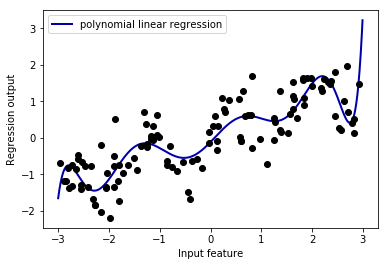

In [27]:
reg = LinearRegression().fit(X_poly, y)

line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='polynomial linear regression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

多項式特徴量はこの1次元のデータに対して、非常にスムーズに適合する。

比較としてカーネル法を用いたSVMモデルを、変換していないオリジナルデータに適用してみる。

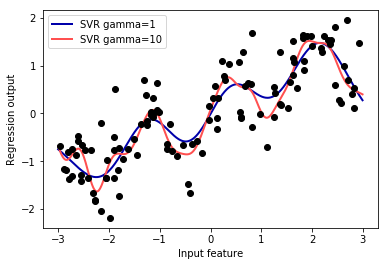

In [28]:
from sklearn.svm import SVR

for gamma in [1, 10]:
    svr = SVR(gamma=gamma).fit(X, y)
    plt.plot(line, svr.predict(line), label='SVR gamma={}'.format(gamma))

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

このように複雑なモデルを用いると、特徴量に対して明示的な変換を行わなくても、多項式回帰と同じように複雑な予測ができる。

*おまけ*

一方で、多項式特徴量を複雑なモデルに適用すると、性能が出ない場合もある。

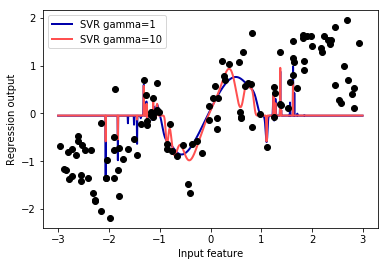

In [29]:
for gamma in [1, 10]:
    svr = SVR(gamma=gamma).fit(X_poly, y)
    plt.plot(line, svr.predict(line_poly), label='SVR gamma={}'.format(gamma))

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")

全てのモデルにおいて盲目的に多項式特徴量を適用すればいい、というわけではないので注意が必要。

<br>

より現実的なタスクに交互作用特徴量と多項式特徴量を適用してみる。


In [30]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, random_state=0)

# データのスケール変換
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ここでは、二次までの多項式特徴量と交互作用を抽出してみる。

In [31]:
poly = PolynomialFeatures(degree=2).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_poly.shape: {}".format(X_train_poly.shape))

X_train.shape: (379, 13)
X_train_poly.shape: (379, 105)


もとの特徴量は13しかなかったが、これを105まで拡張した。  
これらの新しい特徴量は、もとの特徴量から2つの特徴量のすべての組み合わせと、もとの特徴量の二乗で構成される。

ここでdgree=2と指定しているのは、もとの特徴量2つの積までを考慮するという意味であり、  
もちろんdgreeに指定する数を大きくするほど、拡張される特徴量の数は増える。

In [32]:
poly_ex = PolynomialFeatures(degree=3).fit(X_train_scaled)
X_train_poly_ex = poly_ex.transform(X_train_scaled)
X_test_poly_ex = poly_ex.transform(X_test_scaled)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_poly_ex.shape: {}".format(X_train_poly_ex.shape))

X_train.shape: (379, 13)
X_train_poly_ex.shape: (379, 560)


In [33]:
print("Polynomial feature names:\n{}".format(poly.get_feature_names()))

Polynomial feature names:
['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x6 x12', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12', 'x8^2', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x9^2', 'x9 x10', 'x9 x11', 'x9 x12', 'x10^2', 'x10 x11', 'x10 x12', 'x11^2', 'x11 x12', 'x12^2']


最初の特徴量は乗数特徴量で、ここでは"1"と呼ばれている。  

次の13の特徴量はもとの特徴量そのままであり、その次から最初の特徴量の2乗($x0^2$)や、  
最初の特徴量とその他の特徴量の組み合わせが続いている。

Ridgeを使って、交互作用特徴量のあり/なしで比較してみる。

In [38]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(
    ridge.score(X_test_scaled, y_test)))

ridge = Ridge().fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(
    ridge.score(X_test_poly, y_test)))

Score without interactions: 0.621
Score with interactions: 0.753


交互作用特徴量と多項式特徴量は、Ridgeの性能を明らかに押し上げていることがわかる。  
これはデータの表現力が増大されており、線形モデルのような単純なモデルにおいては効果が絶大であるから。

ただし、どのようなモデルであってもいつでも有効なわけではない。

例として、ランダムフォレストのような複雑なモデルを使う場合で比較してみる。

In [35]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100).fit(X_train_scaled, y_train)
print("Score without interactions: {:.3f}".format(
    rf.score(X_test_scaled, y_test)))

rf = RandomForestRegressor(n_estimators=100).fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(rf.score(X_test_poly, y_test)))

Score without interactions: 0.803
Score with interactions: 0.751


そもそも交互作用特徴量や多項式特徴量がなくてもRidgeの性能を上回っている。  
また、特徴量を入れるとわずかに性能が下げっていることがわかる。

このように、採択するモデルによって特徴量を拡張すべきか判断する必要がある。

<br>

---

## おわり

誤字脱字、不明点あればご連絡ください。